In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import mean_squared_error, explained_variance_score
from numpy.linalg import inv, solve
import matplotlib.pyplot as plt
from random import Random, shuffle
from utils_plot import *

In [2]:
# 1. Data Normalization

def preprocessing(eta, M, ampl_threshold=0.1):

    targetnames = np.array(list(set(M.index) & set(eta.index)))
    print("RNAs in common :", len(targetnames))

    eta = eta.loc[targetnames]
    
    indices = list(range(10))
    Random(random_seed).shuffle(indices)
    eta1 = eta.groupby("gene").nth(indices[:5])
    eta2 = eta.groupby("gene").nth(indices[5:])
    
    eta1 = eta1.groupby('gene').mean().to_numpy()
    eta2 = eta2.groupby('gene').mean().to_numpy()
    
    ampl1 = (eta1.max(axis=1)-eta1.min(axis=1))/2
    ampl2 = (eta2.max(axis=1)-eta2.min(axis=1))/2
    ind = (ampl1 > ampl_threshold) & (ampl2 > ampl_threshold)
    eta1, eta2 = eta1[ind,:], eta2[ind,:]
    targetnames_filtered = targetnames[ind]

    M = M.loc[targetnames_filtered].to_numpy()

    # Identify RBPs that are not present in any gene
    inactive_RBPs = np.where(M.sum(axis=0) == 0)[0]
    print(f"Number of inactive RBPs: {len(inactive_RBPs)}")
    M = np.delete(M, inactive_RBPs, axis=1)
    RBP_names_filtered = np.delete(RBP_names, inactive_RBPs)

    print(f"Kept RNAs: {M.shape[0]} (ampl > {ampl_threshold})")
    eta1_norm = eta1 - np.mean(eta1, axis=1, keepdims=True) - np.mean(eta1, axis=0, keepdims=True) + np.mean(eta1)
    eta2_norm = eta2 - np.mean(eta2, axis=1, keepdims=True) - np.mean(eta2, axis=0, keepdims=True) + np.mean(eta2)
    M_norm = M - np.mean(M, axis=0, keepdims=True)

    return eta1_norm, eta2_norm, M_norm, targetnames_filtered, RBP_names_filtered

In [3]:
# 2. Ridge Regression Solver

def ridge_regression_solution(eta_norm, M_norm, lam):
    """
    Solves for A in the ridge regression model:
      (M_norm.T @ M_norm + lam I) * A = M_norm.T @ eta_norm
    Returns A, with shape (n_motifs, n_cells).
    """
    M_term = M_norm.T @ M_norm  # shape: (n_motifs, n_motifs)
    I = np.eye(M_term.shape[0])
    A = solve(M_term + lam * I, M_norm.T @ eta_norm)
    return A

In [4]:
# 3. Cross-Validation to Optimize Lambda
def lambda_optimization(eta1_norm, eta2_norm, M_norm, lam_candidates):
    
    EV_train = []
    EV_test = []
    MSE_train = []
    MSE_test = []
    
    for eta_train, eta_test in [(eta1_norm, eta2_norm), (eta2_norm, eta1_norm)]:
        
        EV_train_fold = []
        EV_test_fold = []
        MSE_train_fold = []
        MSE_test_fold = []
        
        # For each candidate lambda, compute the model predictions.
        for lam in lam_candidates:
            # Fit the ridge regression model on training set:
            A = ridge_regression_solution(eta_train, M_norm, lam)
            # Predictions for training and test sets:
            R = M_norm @ A

            # Compute EV per gene
            EV_train_fold.append(explained_variance_score(eta_train, R))
            EV_test_fold.append(explained_variance_score(eta_test, R))
            
            MSE_train_fold.append(mean_squared_error(eta_train, R))
            MSE_test_fold.append(mean_squared_error(eta_test, R))
            
        EV_train.append(EV_train_fold)
        EV_test.append(EV_test_fold)
        MSE_train.append(MSE_train_fold)
        MSE_test.append(MSE_test_fold)
        
    EV_train = np.array(EV_train)
    EV_test = np.array(EV_test)
    MSE_train = np.array(MSE_train)
    MSE_test = np.array(MSE_test)
        
    avg_EV_test = np.mean(EV_test, axis=0)
    avg_MSE_test = np.mean(MSE_test, axis=0)
    
    # Here, we choose the lambda that gives the highest average EV (you could also choose by lowest MSE).
    best_index = np.argmax(avg_EV_test)
    best_lam = lam_candidates[best_index]
    best_EV = avg_EV_test[best_index]
    best_MSE = avg_MSE_test[best_index]
    
    # Plot the performance metrics vs lambda:
    plt.figure(figsize=(12, 5))

    # Subplot for Explained Variance:
    plt.subplot(1, 2, 1)
    for i in range(2):
        plt.plot(lam_candidates, EV_train[i], linestyle="--", color="green", alpha=0.6, label="Train"+str(i+1))
        plt.plot(lam_candidates, EV_test[i], linestyle="--", color="orange", alpha=0.6, label="Test"+str(i+1))
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("EV")
    plt.title("Explained Variance vs Lambda")
    plt.legend()
    plt.grid(True)
    
    # Subplot for Mean Squared Error:
    plt.subplot(1, 2, 2)
    for i in range(2):
        plt.plot(lam_candidates, MSE_train[i], linestyle="--", color="blue", alpha=0.6, label="Train"+str(i+1))
        plt.plot(lam_candidates, MSE_test[i], linestyle="--", color="magenta", alpha=0.6, label="Test"+str(i+1))
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("MSE vs Lambda")
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    return best_lam, best_EV, best_MSE

In [5]:
#4. Final perf evaluation on best lambda
def train_best_model(eta1_norm, eta2_norm, M_norm, best_lam):
    
    for eta_train, eta_test in [(eta1_norm, eta2_norm), (eta2_norm, eta1_norm)]:
        
        # Fit the ridge regression model on training set:
        A = ridge_regression_solution(eta_train, M_norm, best_lam)
        # Predictions for training and test sets:
        R = M_norm @ A
        
        print("EV_train :", round(explained_variance_score(eta_train, R)*100,2), "%", "MSE_train :", round(mean_squared_error(eta_train, R),3))
        print("EV_test :", round(explained_variance_score(eta_test, R)*100,2), "%", "MSE_test :", round(mean_squared_error(eta_test, R),3), "\n")
     
    return A, eta2_norm, eta1_norm, R

In [6]:
################
#### EXPORT ####
################

RNAs in common : 10890
Number of inactive RBPs: 1
Kept RNAs: 1026 (ampl > 0.2)


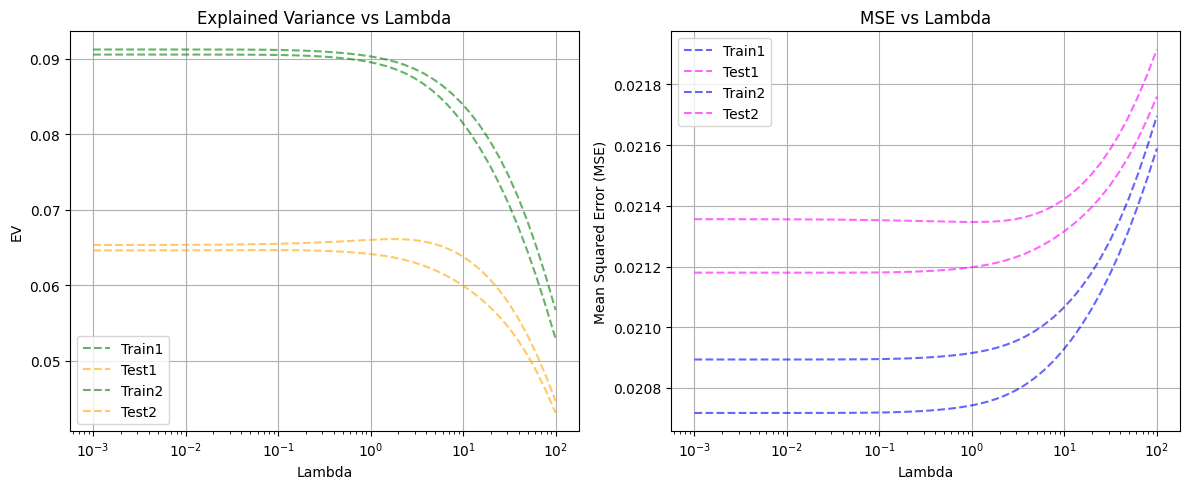

Best lambda: 0.45
Best EV : 6.51 %
Best MSE: 0.021


In [7]:
fileBSM = '/shared/space2/molina/suttyg/ENCORI_mm10_RBPTarget_matrix.txt' # text file with the binding sites matrix that infrom the interactions BP -> Target
fileEta = '/shared/space2/molina/suttyg/bootstrap_eta_snrna_rep1_100_1_1.csv'
process = ["export", "\u03B7"]
theta_smooth = np.round(np.linspace(0.01, 1.00, 100), 2)  # 100 bins from 0.01 to 1.00
lam_candidates = np.logspace(-3, 2, 50)
random_seed = 41

M = pd.read_csv(fileBSM, sep="\t",index_col=0)
M = M.drop(M.columns[-1], axis=1)
RBP_names = M.columns
eta = pd.read_csv(fileEta, sep=",",index_col=0)

#Select common genes and normalize
ampl_threshold=0.2
eta1_norm, eta2_norm, M_norm, targetnames, RBP_names = preprocessing(eta, M, ampl_threshold=ampl_threshold)

# Define candidate lambda values (you may adjust this range as needed)
best_lam, best_EV, best_MSE = lambda_optimization(eta1_norm, eta2_norm, M_norm, lam_candidates)
print("Best lambda:", round(best_lam, 3))
print("Best EV :", round(best_EV*100,2), "%")
print("Best MSE:", round(best_MSE, 3))

In [8]:
A, eta_train, eta_test, R = train_best_model(eta1_norm, eta2_norm, M_norm, best_lam)

EV_train : 9.01 % MSE_train : 0.021
EV_test : 6.58 % MSE_test : 0.021 

EV_train : 9.08 % MSE_train : 0.021
EV_test : 6.45 % MSE_test : 0.021 



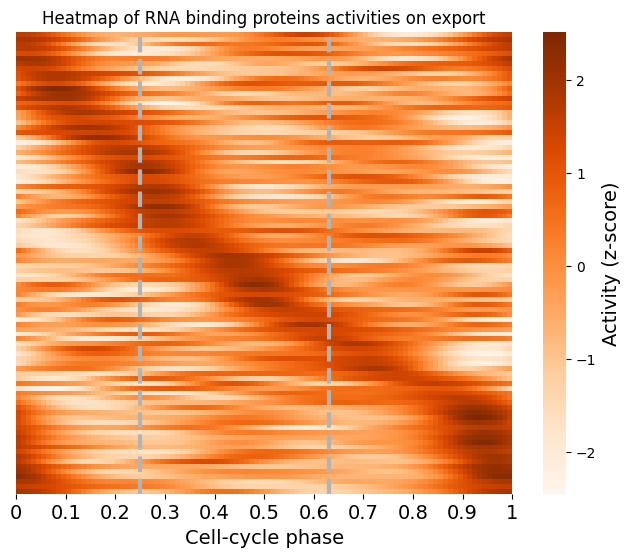

In [9]:
#Heatmap of BPs activity along cell cycle (Export)
#RBP_displayed = plot_heatmap(A, ylabels=RBP_names, display_limit=25)
RBP_displayed = plot_heatmap(A, cmap="Oranges", title="RNA binding proteins activities on export")
#print(RBP_displayed)

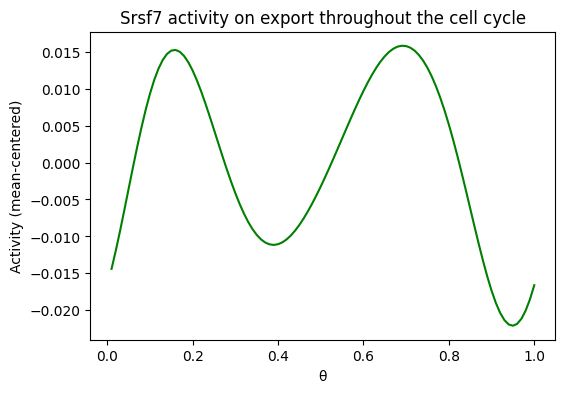

In [10]:
BP_nb = np.where(RBP_names == 'Srsf7')[0][0]
#BP_nb = 2
plot_binding_protein_activity(RBP_names, A, process, theta_smooth, BP_nb=BP_nb)

Train


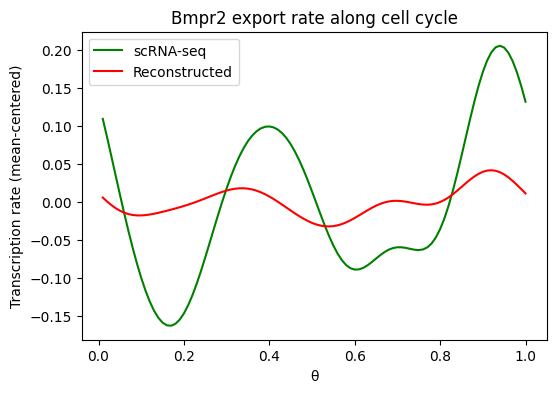

Test


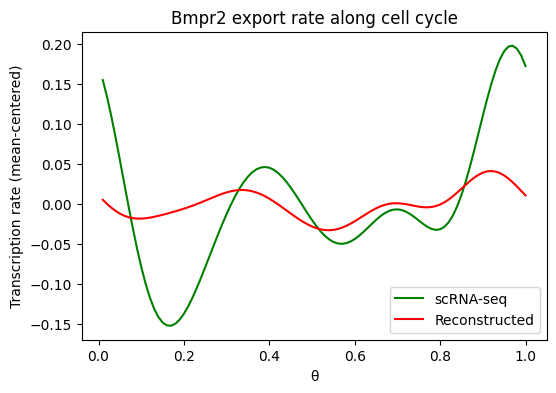

In [11]:
#n = np.where(targetnames == 'Nusap1')[0][0]
n = 51
print("Train")
plot_rate_comparison(targetnames, eta_train, R, process, theta_smooth, target_nb=n)
print("Test")
plot_rate_comparison(targetnames, eta_test, R, process, theta_smooth, target_nb=n)